<a href="https://colab.research.google.com/github/nrajmalwar/EVA-6-Phase-1/blob/main/Session_06/Batch_Normalization_and_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check the GPU

In [2]:
!nvidia-smi

Fri Jun 11 14:27:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
!pip install torchsummary
from torchsummary import summary
from torch.utils.data import DataLoader

from models.model import Net
from utils.train import train
from utils.test import test
from plots.plot import display_misclassified_images

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Data Transformations


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([

                                       transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [5]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = DataLoader(test_data, **dataloader_args)

CUDA Available? True


# Model Training Loop

In [7]:
EPOCHS = 20

In [8]:
def train_test_display(model, epochs, l1_reg=False):
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  # model =  model.Net(bn_type).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

  # LR Scheduler
  lambda1 = lambda epoch: 0.85 ** epoch
  scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

  for epoch in range(0, epochs):
      print("EPOCH:", epoch+1)
      acc, loss = train(model, device, train_loader, optimizer, epoch, l1_reg)
      # Since accuracy and loss are returned as a list, we expand it using +
      train_acc += acc
      train_losses += loss
      scheduler.step()
      acc, loss = test(model, device, test_loader)
      test_acc += acc
      test_losses += loss

  return test_acc, test_losses, train_acc, train_losses

# **Batch Normalization + L1 Regularization**

In [9]:
model = Net('BN').to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
            Conv2d-8           [-1, 10, 24, 24]             200
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 20, 10, 10]           1,800
             ReLU-11           [-1, 20, 10, 10]               0
      BatchNorm2d-12           [-1, 20, 10, 10]              40
          Dropout-13           [-1, 20, 10, 10]               0
           Conv2d-14             [-1, 1

In [10]:
print("\n********* Using Batch Normalization **************\n")
test_acc_bn, test_losses_bn, train_acc_bn, train_losses_bn = train_test_display(model, EPOCHS, l1_reg=True)

  0%|          | 0/469 [00:00<?, ?it/s]


********* Using Batch Normalization **************

EPOCH: 1


Loss=0.5290122628211975 Batch_id=468 Accuracy=91.56: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2622, Accuracy: 9157/10000 (91.57%)

EPOCH: 2


Loss=0.5713653564453125 Batch_id=468 Accuracy=95.51: 100%|██████████| 469/469 [00:22<00:00, 20.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1769, Accuracy: 9429/10000 (94.29%)

EPOCH: 3


Loss=0.4336012303829193 Batch_id=468 Accuracy=95.90: 100%|██████████| 469/469 [00:22<00:00, 20.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2574, Accuracy: 9172/10000 (91.72%)

EPOCH: 4


Loss=0.3562234342098236 Batch_id=468 Accuracy=96.19: 100%|██████████| 469/469 [00:23<00:00, 20.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1431, Accuracy: 9534/10000 (95.34%)

EPOCH: 5


Loss=0.5098544359207153 Batch_id=468 Accuracy=96.32: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2063, Accuracy: 9318/10000 (93.18%)

EPOCH: 6


Loss=0.49402979016304016 Batch_id=468 Accuracy=96.58: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1472, Accuracy: 9500/10000 (95.00%)

EPOCH: 7


Loss=0.3233432173728943 Batch_id=468 Accuracy=96.71: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1066, Accuracy: 9681/10000 (96.81%)

EPOCH: 8


Loss=0.31785768270492554 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:22<00:00, 20.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1215, Accuracy: 9617/10000 (96.17%)

EPOCH: 9


Loss=0.31533822417259216 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:22<00:00, 20.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1098, Accuracy: 9670/10000 (96.70%)

EPOCH: 10


Loss=0.34314388036727905 Batch_id=468 Accuracy=96.93: 100%|██████████| 469/469 [00:22<00:00, 20.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0985, Accuracy: 9681/10000 (96.81%)

EPOCH: 11


Loss=0.31283628940582275 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:22<00:00, 20.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1093, Accuracy: 9672/10000 (96.72%)

EPOCH: 12


Loss=0.28692737221717834 Batch_id=468 Accuracy=97.13: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0902, Accuracy: 9729/10000 (97.29%)

EPOCH: 13


Loss=0.28638026118278503 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0830, Accuracy: 9742/10000 (97.42%)

EPOCH: 14


Loss=0.36665940284729004 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:22<00:00, 20.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1247, Accuracy: 9614/10000 (96.14%)

EPOCH: 15


Loss=0.19700370728969574 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:23<00:00, 20.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0528, Accuracy: 9832/10000 (98.32%)

EPOCH: 16


Loss=0.24523420631885529 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:23<00:00, 20.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9863/10000 (98.63%)

EPOCH: 17


Loss=0.21628974378108978 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:22<00:00, 20.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Accuracy: 9827/10000 (98.27%)

EPOCH: 18


Loss=0.23576463758945465 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:22<00:00, 20.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0913, Accuracy: 9691/10000 (96.91%)

EPOCH: 19


Loss=0.3231750726699829 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:22<00:00, 20.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9810/10000 (98.10%)

EPOCH: 20


Loss=0.24684160947799683 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]



Test set: Average loss: 0.0489, Accuracy: 9859/10000 (98.59%)




********* Misclassified Images **************



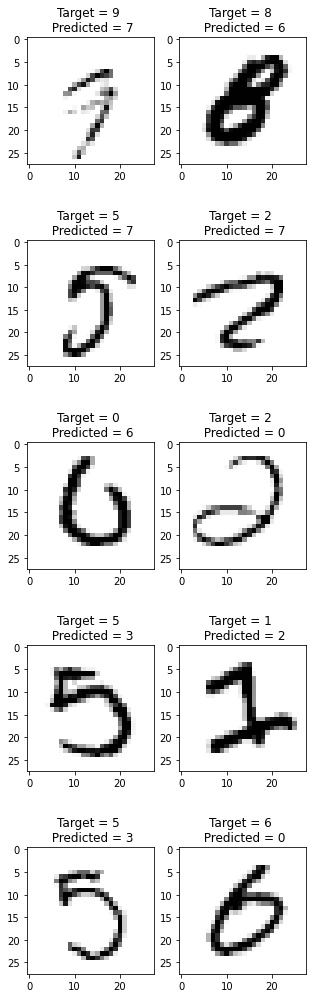

In [11]:
display_misclassified_images(model, test_data, device=device)

# **Layer Normalization**

In [12]:
model = Net('LN').to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
         GroupNorm-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
         GroupNorm-7           [-1, 20, 24, 24]              40
            Conv2d-8           [-1, 10, 24, 24]             200
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 20, 10, 10]           1,800
             ReLU-11           [-1, 20, 10, 10]               0
        GroupNorm-12           [-1, 20, 10, 10]              40
          Dropout-13           [-1, 20, 10, 10]               0
           Conv2d-14             [-1, 1

In [13]:
print("\n********* Using Layer Normalization **************\n")
test_acc_ln, test_losses_ln, train_acc_ln, train_losses_ln = train_test_display(model, EPOCHS)

  0%|          | 0/469 [00:00<?, ?it/s]


********* Using Layer Normalization **************

EPOCH: 1


Loss=0.06704318523406982 Batch_id=468 Accuracy=88.50: 100%|██████████| 469/469 [00:22<00:00, 21.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0639, Accuracy: 9809/10000 (98.09%)

EPOCH: 2


Loss=0.06875210255384445 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:22<00:00, 21.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 9843/10000 (98.43%)

EPOCH: 3


Loss=0.041763126850128174 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:22<00:00, 21.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9853/10000 (98.53%)

EPOCH: 4


Loss=0.07245294004678726 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Loss=0.04217846691608429 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9909/10000 (99.09%)

EPOCH: 6


Loss=0.018895482644438744 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.029829619452357292 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:22<00:00, 21.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9920/10000 (99.20%)

EPOCH: 8


Loss=0.003922016825526953 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:22<00:00, 21.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.011823806911706924 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:22<00:00, 21.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.007884707301855087 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:21<00:00, 21.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.035976119339466095 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:21<00:00, 21.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.008906413801014423 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.005933607462793589 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:22<00:00, 20.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9944/10000 (99.44%)

EPOCH: 14


Loss=0.044059038162231445 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:22<00:00, 21.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.05326812341809273 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:22<00:00, 21.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.09474494308233261 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH: 17


Loss=0.04581649228930473 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:21<00:00, 21.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9945/10000 (99.45%)

EPOCH: 18


Loss=0.012542872689664364 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:22<00:00, 21.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)

EPOCH: 19


Loss=0.0016462174244225025 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:22<00:00, 21.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9943/10000 (99.43%)

EPOCH: 20


Loss=0.049326952546834946 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]



Test set: Average loss: 0.0182, Accuracy: 9942/10000 (99.42%)




********* Misclassified Images **************



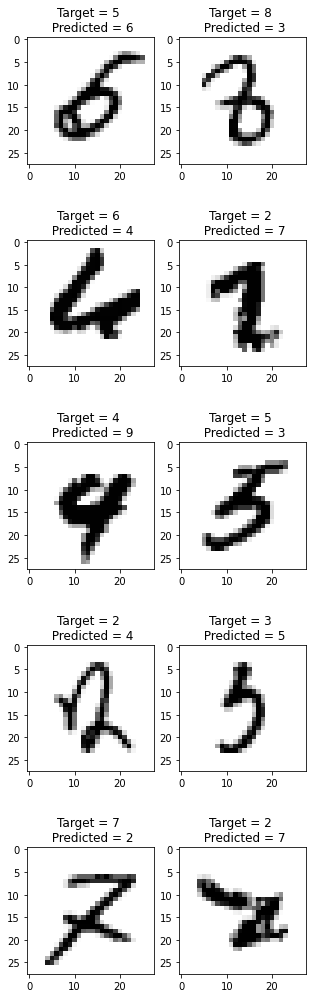

In [14]:
display_misclassified_images(model, test_data, device=device)

# **Group Normalization**

In [15]:
model = Net('GN').to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
         GroupNorm-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
         GroupNorm-7           [-1, 20, 24, 24]              40
            Conv2d-8           [-1, 10, 24, 24]             200
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 20, 10, 10]           1,800
             ReLU-11           [-1, 20, 10, 10]               0
        GroupNorm-12           [-1, 20, 10, 10]              40
          Dropout-13           [-1, 20, 10, 10]               0
           Conv2d-14             [-1, 1

In [16]:
print("\n********* Using Group Normalization **************\n")
test_acc_gn, test_losses_gn,train_acc_gn,train_losses_gn = train_test_display(model, EPOCHS)

  0%|          | 0/469 [00:00<?, ?it/s]


********* Using Group Normalization **************

EPOCH: 1


Loss=0.16489169001579285 Batch_id=468 Accuracy=89.81: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0843, Accuracy: 9754/10000 (97.54%)

EPOCH: 2


Loss=0.1260586380958557 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:22<00:00, 21.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9846/10000 (98.46%)

EPOCH: 3


Loss=0.05548310652375221 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:21<00:00, 21.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9869/10000 (98.69%)

EPOCH: 4


Loss=0.035385776311159134 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:21<00:00, 21.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9875/10000 (98.75%)

EPOCH: 5


Loss=0.021389037370681763 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:22<00:00, 21.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9927/10000 (99.27%)

EPOCH: 6


Loss=0.05767073854804039 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:22<00:00, 21.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.06490663439035416 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.023262856528162956 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:22<00:00, 21.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.08483979105949402 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:21<00:00, 21.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.01677645929157734 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:21<00:00, 21.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.021399514749646187 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.013172485865652561 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:21<00:00, 21.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.07250369340181351 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:21<00:00, 21.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.01942547596991062 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:21<00:00, 21.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.005107125733047724 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:21<00:00, 21.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.028008798137307167 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:21<00:00, 21.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9946/10000 (99.46%)

EPOCH: 17


Loss=0.017589224502444267 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9944/10000 (99.44%)

EPOCH: 18


Loss=0.0055484832264482975 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:21<00:00, 21.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9947/10000 (99.47%)

EPOCH: 19


Loss=0.014934989623725414 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:21<00:00, 21.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9945/10000 (99.45%)

EPOCH: 20


Loss=0.008079287596046925 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:22<00:00, 21.23it/s]



Test set: Average loss: 0.0195, Accuracy: 9948/10000 (99.48%)




********* Misclassified Images **************



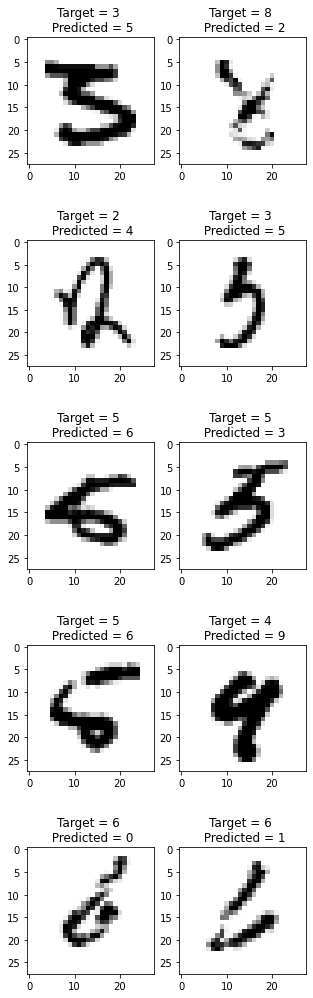

In [17]:
display_misclassified_images(model, test_data, device=device)

# **Let's Plot graphs**



Text(0.5, 1.0, 'Test Accuracy')

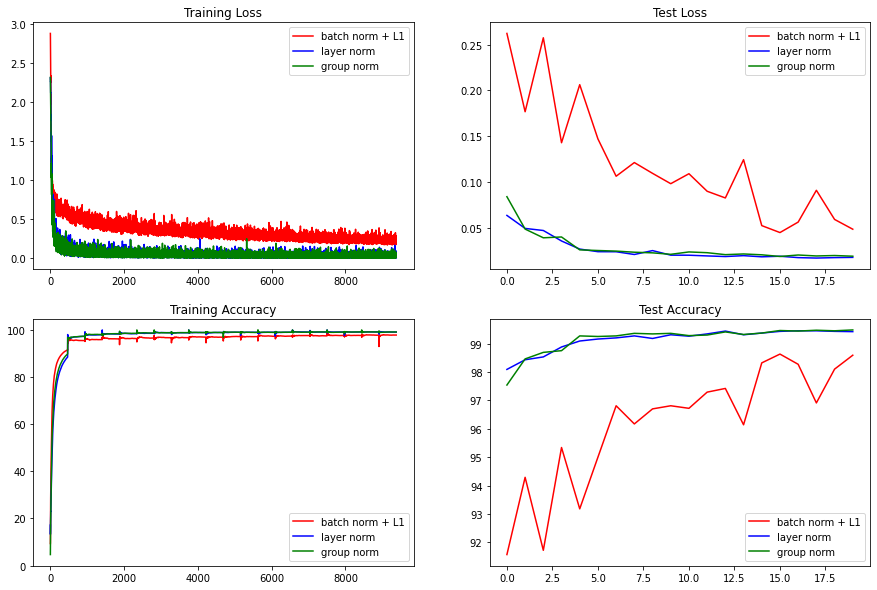

In [18]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_bn,'-r',label='batch norm + L1')
axs[0, 0].plot(train_losses_ln,'-b',label='layer norm')
axs[0, 0].plot(train_losses_gn,'-g',label='group norm')
axs[0, 0].legend(loc="upper right")
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_bn,'r',label='batch norm + L1')
axs[1, 0].plot(train_acc_ln,'b',label='layer norm')
axs[1, 0].plot(train_acc_gn,'g',label='group norm')
axs[1, 0].legend(loc="lower right")
axs[1, 0].set_title("Training Accuracy")

epochs =[x for x in range(15)]
axs[0, 1].plot(test_losses_bn,'r',label='batch norm + L1')
axs[0, 1].plot(test_losses_ln,'b',label='layer norm')
axs[0, 1].plot(test_losses_gn,'g',label='group norm')
axs[0, 1].legend(loc="upper right")
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_bn,'r',label='batch norm + L1')
axs[1, 1].plot(test_acc_ln,'b',label='layer norm')
axs[1, 1].plot(test_acc_gn,'g',label='group norm')
axs[1, 1].legend(loc="lower right")
axs[1, 1].set_title("Test Accuracy")